<a href="https://colab.research.google.com/github/princesinha24/Liver_class/blob/master/IncetionResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install pkbar
import pkbar

In [ ]:
batch_size= 32
device = 'cuda'
num_classes= 4
input_shape=(3,224,224)

In [ ]:
main = 'drive/My Drive/KMC Dataset'
work = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir'

train_dir = os.path.join(main,'Training')
test_dir = os.path.join(main,'Test')
val_dir = os.path.join(main,'Validation')

In [ ]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [ ]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
class_dict=train_data.class_to_idx
print(class_dict)
class_labels = class_dict.values()
print(class_labels)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}
dict_values([0, 1, 2, 3])


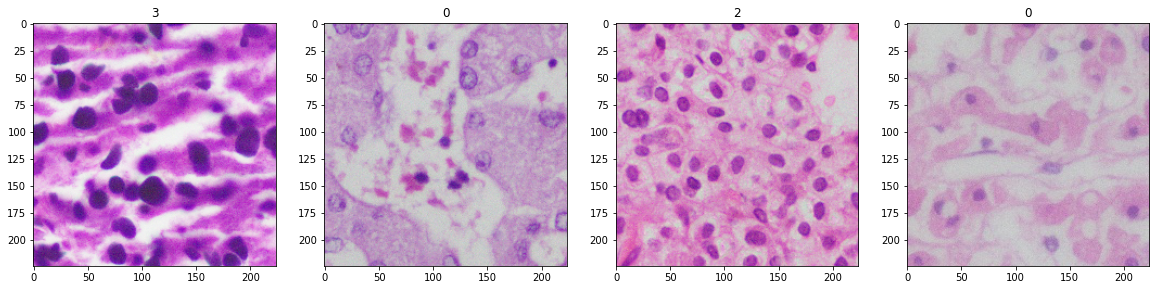

In [ ]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(4):
    plt.subplot(1,4,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show() 





# Model defination

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.conv3 = nn.Conv2d(inter_planes, out_planes, kernel_size=5, stride=1,
                               padding=2, bias=False)
        self.conv4 = nn.Conv2d(inter_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(3*out_planes)
        self.conv5 = nn.Conv2d(3*out_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out1 = self.conv2(self.relu2(self.bn2(out)))
        out2 = self.conv3(self.relu2(self.bn2(out)))
        out3 = self.conv4(self.relu2(self.bn2(out)))
        out=torch.cat([out1,out2,out3],1)
        out=self.conv5(self.relu2(self.bn3(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

In [ ]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
        self.avg_pool=nn.AvgPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return self.avg_pool(out)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=4, growth_rate=32,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet, self).__init__()
        in_planes = 64
        if bottleneck == True:
            block = BottleneckBlock
        else:
            block = BasicBlock
        # 1st conv before any dense block
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,
                                padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 1st block
        self.block1 = DenseBlock(6, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+6*growth_rate)
        self.trans1 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        
        # 2nd block
        self.block2 = DenseBlock(12, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+12*growth_rate)
        self.trans2 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
        
        # 3rd block
        self.block3 = DenseBlock(24, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+24*growth_rate)
        self.trans3 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
       
        #4th block
        self.block4 = DenseBlock(16, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+16*growth_rate)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool=nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(in_planes, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.in_planes = in_planes
    def forward(self, x):
        out = self.layer1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.trans3(self.block3(out))
        out = self.block4(out)
        out = self.relu(self.bn1(out))
        out = self.avg_pool(out)
        out = out.view(-1, self.in_planes)
        out=  self.fc1(out)
        return self.fc2(out)

In [ ]:
model = DenseNet().to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]         102,400
      BatchNorm2d-14          [-1, 128,

In [ ]:
learning_rate = 1e-5
num_epochs = 50

In [ ]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf

for epoch in range(num_epochs):
  train_losses=[]
### TRAINING
  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:
    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP
    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)
    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION
  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)
  for batch_idx, (data, targets) in val_loop:
    val_losses=[]
    model.eval()
   
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/50
83/83 [==============================] - 908s 11s/step - loss: 0.9281 - accuracy: 0.6799
Epoch: 1/50
9/9 [==============================] - 79s 9s/step - val_loss: 0.7075 - val_accuracy: 0.7487
Epoch: 2/50
83/83 [==============================] - 64s 771ms/step - loss: 0.4680 - accuracy: 0.8358
Epoch: 2/50
9/9 [==============================] - 3s 322ms/step - val_loss: 0.4675 - val_accuracy: 0.7956
Epoch: 3/50
83/83 [==============================] - 65s 779ms/step - loss: 0.3263 - accuracy: 0.8711
Epoch: 3/50
9/9 [==============================] - 3s 332ms/step - val_loss: 0.3666 - val_accuracy: 0.8503
Epoch: 4/50
83/83 [==============================] - 65s 785ms/step - loss: 0.2356 - accuracy: 0.9101
Epoch: 4/50
9/9 [==============================] - 3s 328ms/step - val_loss: 0.3279 - val_accuracy: 0.8750
Epoch: 5/50
83/83 [==============================] - 65s 788ms/step - loss: 0.1895 - accuracy: 0.9241
Epoch: 5/50
9/9 [==============================] - 3s 327ms/step 

In [ ]:
def check_accuracy(loader, model):
    #confusion matrix
    con=np.zeros([4,4],dtype=np.long)
    

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            #print (predictions,y)
            for i in range(y.size(0)):
              con[predictions[i]][y[i]]+=1
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print (con)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()
    return con

In [ ]:
con_train=check_accuracy(train_loader, model)
con_test=check_accuracy(test_loader, model)

[[672   0   0   0]
 [  0 640   0   0]
 [  0   0 670   0]
 [  0   0   0 665]]
Got 2647 / 2647 with accuracy 100.00
[[70  0  0  0]
 [ 0 68  8  5]
 [ 0 12 72  0]
 [ 0  0  0 45]]
Got 255 / 280 with accuracy 91.07
